In [1]:
import os
import argparse
from importlib import import_module
import shutil
import json

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchsso
from torchsso.optim import SecondOrderOptimizer, VIOptimizer
from torchsso.utils import Logger
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.calibration import calibration_curve

np.set_printoptions(threshold=np.inf)

In [2]:
def feature_extraction(optimizer='Bayessian',dataset='DATASET_CIFAR10',data_augmentation = False,download = True):
    
    '''
    Return a dictionary containing features extracted from different layers of LeNet5 with batch normalization'

    Parameters:
        optimizer: ['Bayessian','Adam']
                    default == Bayessian
        dataset:['DATASET_CIFAR10','DATASET_SVHN','DATASET_MNIST','DATASET_Places365','DATASET_Texture']
                default == 'DATASET_CIFAR10' 
        data_augmentation:[True, False]
                          default == False
        download: [True,False]
                  default == True
    '''   

    if optimizer == 'Bayessian':
        configpath = 'configs/lenet_vogn_feature.json'
        ckptpath = './ckpts/adam_epoch30_ckp.ckpt'
    elif optimizer == 'Adam':
        configpath = 'configs/lenet_adam_feature.json'
        ckptpath = './ckpts/bay_epoch30_ckp.ckpt'
    else:
        print('Not Available Optimizer')   
        return

    ## load config file    
    with open(configpath) as f:
        config = json.load(f)

    ## set up
    device = ("cuda" if torch.cuda.is_available() else "cpu")
    batchsize = config['batch_size']

    ## load data pre-processing
    data_transforms = []
    if data_augmentation == True:
        ## random crop
        data_transforms.append(transforms.RandomCrop(32, padding=4))
        ## random horizontal flip
        data_transforms.append(transforms.RandomHorizontalFlip())
        ## style augmentation
        ## 接口 @Max
    if dataset == 'DATASET_MNIST':
        colorized = transforms.Grayscale(num_output_channels = 3)
        resized = transforms.Resize(32)
        data_transforms.append(colorized)
        data_transforms.append(resized)
    data_transforms.append(transforms.ToTensor())  
    if config['normalizing_data'] == True: 
        normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        data_transforms.append(normalize)     
    transform = transforms.Compose(data_transforms)  
    
    ## load data
    if dataset == 'DATASET_CIFAR10':
        # CIFAR-10
        num_classes = 10
        dataset_class = datasets.CIFAR10
    elif dataset == 'DATASET_SVHN':
        ## SVHN
        num_classes = 10
        dataset_class = datasets.SVHN
    elif dataset == 'DATASET_MNIST':
        ## MNIST
        num_classes = 10
        dataset_class = datasets.MNIST
    elif dataset == 'DATASET_Texture':
        ## Texture
        num_classes = 47
        dataset_class = datasets.DTD
    elif dataset == 'DATASET_Places365':
        ## Places365
        num_classes = 434
        dataset_class = datasets.Places365
    else:
        print('Unknown Dataset')
        return
        
    dataset = dataset_class(root='./data', download=download, transform=transform)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True, num_workers=0)    
    print('Data Loading Done')
    
    ## load model  
    _, ext = os.path.splitext(config['arch_file'])
    dirname = os.path.dirname(config['arch_file'])
    module_path = '.'.join(os.path.split(config['arch_file'])).replace(ext, '')
    module = import_module(module_path)
    arch_class = getattr(module, config['arch_name'])
    num_classes = 10
    arch_kwargs = {} if config['arch_args'] == 'None' else config['arch_args']
    arch_kwargs['num_classes'] = num_classes
    model = arch_class(**arch_kwargs)
    setattr(model, 'num_classes', num_classes)
    model.to(device)
    print('Model Loading Done')
    
    
    ## load checkpoint and update model
    checkpoint = torch.load(ckptpath)
    print('checkpoint path: ' + ckptpath)
    model.load_state_dict(checkpoint['model'])
    
    
    ## extract features
    model.eval()

    feature1_ls = []                                                     
    feature2_ls = []
    feature3_ls = []                                                     
    with torch.no_grad():
        for data, target in data_loader:

            data, target = data.to(device), target.to(device)  
            output,feature1,feature2,feature3 = model(data)

            feature1_ls.append(feature1.detach().cpu().numpy().reshape(-1,1))
            feature2_ls.append(feature2.detach().cpu().numpy().reshape(-1,1))
            feature3_ls.append(feature3.detach().cpu().numpy().reshape(-1,1))

    features = {'feature1':feature1_ls,'feature2':feature2_ls,'feature3':feature3_ls}        
    print('Successfully Extract Features !')
    
    return features

In [62]:
def entropy_extraction(optimizer='Bayessian',dataset='DATASET_CIFAR10',data_augmentation = False,download = True):
    
    '''
    Return a dictionary containing features extracted from different layers of LeNet5 with batch normalization'

    Parameters:
        optimizer: ['Bayessian','Adam']
                    default == Bayessian
        dataset:['DATASET_CIFAR10','DATASET_SVHN','DATASET_MNIST','DATASET_Places365','DATASET_Texture']
                default == 'DATASET_CIFAR10' 
        data_augmentation:[True, False]
                          default == False
        download: [True,False]
                  default == True
    '''   

    if optimizer == 'Bayessian':
        configpath = 'configs/lenet_vogn_feature.json'
        ckptpath = './ckpts/adam_epoch30_ckp.ckpt'
    elif optimizer == 'Adam':
        configpath = 'configs/lenet_adam_feature.json'
        ckptpath = './ckpts/bay_epoch30_ckp.ckpt'
    else:
        print('Not Available Optimizer')   
        return

    ## load config file    
    with open(configpath) as f:
        config = json.load(f)

    ## set up
    device = ("cuda" if torch.cuda.is_available() else "cpu")
    batchsize = config['batch_size']

    ## load data pre-processing
    data_transforms = []
    if data_augmentation == True:
        ## random crop
        data_transforms.append(transforms.RandomCrop(32, padding=4))
        ## random horizontal flip
        data_transforms.append(transforms.RandomHorizontalFlip())
        ## style augmentation
        ## 接口 @Max
    if dataset == 'DATASET_MNIST':
        colorized = transforms.Grayscale(num_output_channels = 3)
        resized = transforms.Resize(32)
        data_transforms.append(colorized)
        data_transforms.append(resized)
    data_transforms.append(transforms.ToTensor())  
    if config['normalizing_data'] == True: 
        normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        data_transforms.append(normalize)     
    transform = transforms.Compose(data_transforms)  
    
    ## load data
    if dataset == 'DATASET_CIFAR10':
        # CIFAR-10
        num_classes = 10
        dataset_class = datasets.CIFAR10
    elif dataset == 'DATASET_SVHN':
        ## SVHN
        num_classes = 10
        dataset_class = datasets.SVHN
    elif dataset == 'DATASET_MNIST':
        ## MNIST
        num_classes = 10
        dataset_class = datasets.MNIST
    elif dataset == 'DATASET_Texture':
        ## Texture
        num_classes = 47
        dataset_class = datasets.DTD
    elif dataset == 'DATASET_Places365':
        ## Places365
        num_classes = 434
        dataset_class = datasets.Places365
    else:
        print('Unknown Dataset')
        return
        
    dataset = dataset_class(root='./data', download=download, transform=transform)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True, num_workers=0)    
    print('Data Loading Done')
    
    ## load model  
    _, ext = os.path.splitext(config['arch_file'])
    dirname = os.path.dirname(config['arch_file'])
    module_path = '.'.join(os.path.split(config['arch_file'])).replace(ext, '')
    module = import_module(module_path)
    arch_class = getattr(module, config['arch_name'])
    num_classes = 10
    arch_kwargs = {} if config['arch_args'] == 'None' else config['arch_args']
    arch_kwargs['num_classes'] = num_classes
    model = arch_class(**arch_kwargs)
    setattr(model, 'num_classes', num_classes)
    model.to(device)
    print('Model Loading Done')
    
    
    ## load checkpoint and update model
    checkpoint = torch.load(ckptpath)
    print('checkpoint path: ' + ckptpath)
    model.load_state_dict(checkpoint['model'])
    
    
    ## extract features
    model.eval()
 
    entropy_ls = []
    probtrue_ls = []
    probpred_ls = []
    with torch.no_grad():
        for k,(data, target) in enumerate(data_loader):
            data, target = data.to(device), target.to(device)  
            output,feature1,feature2,feature3 = model(data)
            output = F.softmax(output,dim=1).detach().cpu().numpy()
            ## add eplison to avoid 0
            output = output + 0.0001
            ## calculate predictive entropy
            entropy = np.sum(-np.log(output)*output,axis = 1)
            entropy_ls.append(list(entropy))

    entropy_collection = [item for sublist in entropy_ls for item in sublist]
     
    print(len(entropy_collection))
    print('Successfully Extract Predictive Entropy !')
    
    ## plot
    
    return entropy_collection

In [63]:
entropy1_adam = entropy_extraction(optimizer='Adam',dataset='DATASET_CIFAR10',data_augmentation = False,download = True)
entropy2_adam = entropy_extraction(optimizer='Adam',dataset='DATASET_MNIST',data_augmentation = False,download = True)
entropy3_adam = entropy_extraction(optimizer='Adam',dataset='DATASET_SVHN',data_augmentation = False,download = True)
entropy4_adam = entropy_extraction(optimizer='Adam',dataset='DATASET_DTD',data_augmentation = False,download = False)

Files already downloaded and verified
Data Loading Done
Model Loading Done
checkpoint path: ./result_adam_Apr19/ckpts/epoch20_ckp.ckpt
50000
Successfully Extract Predictive Entropy !
Data Loading Done
Model Loading Done
checkpoint path: ./result_adam_Apr19/ckpts/epoch20_ckp.ckpt
60000
Successfully Extract Predictive Entropy !
Using downloaded and verified file: ./data/train_32x32.mat
Data Loading Done
Model Loading Done
checkpoint path: ./result_adam_Apr19/ckpts/epoch20_ckp.ckpt
73257
Successfully Extract Predictive Entropy !
Unknown Dataset


In [64]:
entropy1 = entropy_extraction(optimizer='Bayessian',dataset='DATASET_CIFAR10',data_augmentation = False,download = True)
entropy2 = entropy_extraction(optimizer='Bayessian',dataset='DATASET_MNIST',data_augmentation = False,download = True)
entropy3 = entropy_extraction(optimizer='Bayessian',dataset='DATASET_SVHN',data_augmentation = False,download = True)
entropy4 = entropy_extraction(optimizer='Bayessian',dataset='DATASET_DTD',data_augmentation = False,download = False)

Files already downloaded and verified
Data Loading Done
Model Loading Done
checkpoint path: ./result_bayes_Apr18/ckpts/epoch20_ckp.ckpt
50000
Successfully Extract Predictive Entropy !
Data Loading Done
Model Loading Done
checkpoint path: ./result_bayes_Apr18/ckpts/epoch20_ckp.ckpt
60000
Successfully Extract Predictive Entropy !
Using downloaded and verified file: ./data/train_32x32.mat
Data Loading Done
Model Loading Done
checkpoint path: ./result_bayes_Apr18/ckpts/epoch20_ckp.ckpt
73257
Successfully Extract Predictive Entropy !
Unknown Dataset


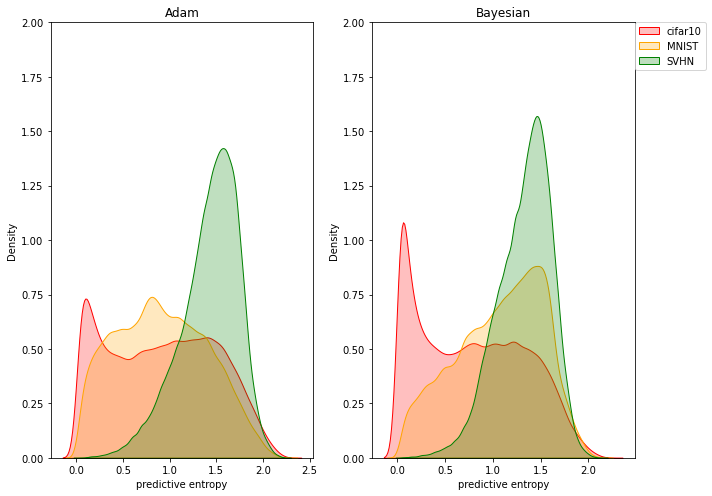

In [72]:
plt.figure(figsize=(10,7))
## adam 
plt.subplot(121)
sns.kdeplot(entropy1_adam,bw_adjust=0.8,color='red',label='cifar10',shade=True)
sns.kdeplot(entropy2_adam,bw_adjust=0.8,color='orange',label='MNIST',shade=True)
sns.kdeplot(entropy3_adam,bw_adjust=0.8,color='green',label='SVHN',shade=True)

plt.title('Adam')
plt.xlabel('predictive entropy')
plt.ylim((0,2))

#plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)


## bayessian 
plt.subplot(122)
sns.kdeplot(entropy1,bw_adjust=0.8,color='red',label='cifar10',shade=True)
sns.kdeplot(entropy2,bw_adjust=0.8,color='orange',label='MNIST',shade=True)
sns.kdeplot(entropy3,bw_adjust=0.8,color='green',label='SVHN',shade=True)
plt.title('Bayesian')


plt.xlabel('predictive entropy')
plt.ylim((0,2))

plt.legend(loc=2, bbox_to_anchor=(1.0,1.0),borderaxespad = 0.)
plt.tight_layout()
plt.savefig('entropy.png',dpi=300)
plt.show()

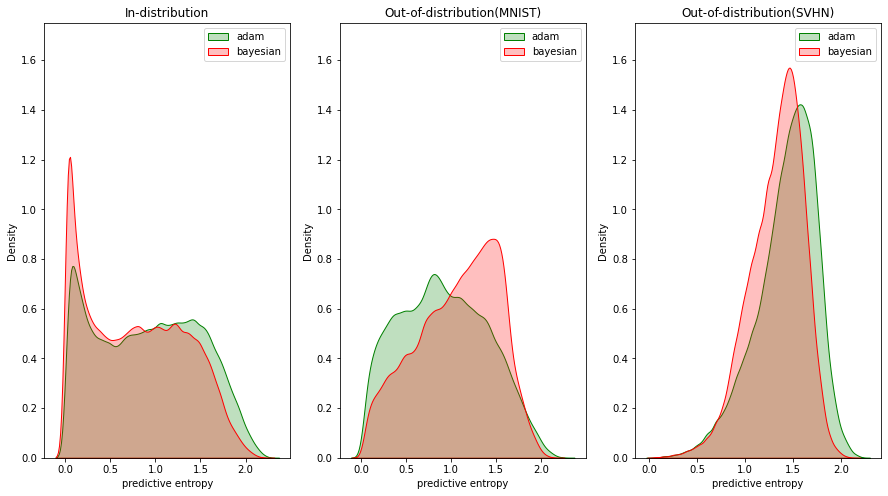

In [67]:
plt.figure(figsize=(15,8))
## in
plt.subplot(131)
sns.kdeplot(entropy1_adam,bw_adjust=0.6,color='green',label='adam',shade=True)
sns.kdeplot(entropy1,bw_adjust=0.6,color='red',label='bayesian',shade=True)
plt.title('In-distribution')
plt.xlabel('predictive entropy')
plt.legend()
plt.ylim((0,1.75))


## out1
plt.subplot(132)
sns.kdeplot(entropy2_adam,bw_adjust=0.8,color='green',label='adam',shade=True)
sns.kdeplot(entropy2,bw_adjust=0.8,color='red',label='bayesian',shade=True)
plt.title('Out-of-distribution(MNIST)')
plt.xlabel('predictive entropy')
plt.legend()
plt.ylim((0,1.75))

## out2
plt.subplot(133)
sns.kdeplot(entropy3_adam,bw_adjust=0.8,color='green',label='adam',shade=True)
sns.kdeplot(entropy3,bw_adjust=0.8,color='red',label='bayesian',shade=True)
plt.title('Out-of-distribution(SVHN)')
plt.xlabel('predictive entropy')
plt.legend()
plt.ylim((0,1.75))

plt.savefig('entropy2.pdf',dpi=300)
plt.show()

In [324]:
filepath = './result_adam_Apr18/log.txt'
acc_ls = []
with open(filepath,'r') as f:
    for line in f:
        #print(line)
        sep = line.replace(' ','').replace('\n','').replace(',','').split(':')
        #print(sep)
        #print('*')
        if sep[0] == '"val_accuracy"':
            print(sep[1])
            acc_ls.append(float(sep[1])/100)

54.99
59.83
61.74
62.93
63.2
63.67
64.0
65.84
66.18
64.64
66.23
67.04
65.93
65.29
66.37
64.83
66.71
65.96
67.86
67.42
66.05
68.22
67.36
67.02
66.59
66.6
66.8
67.95
67.65
67.29


In [325]:
filepath = './result_bayes_Apr18/log.txt'
acc_ls_bay = []
with open(filepath,'r') as f:
    for line in f:
        #print(line)
        sep = line.replace(' ','').replace('\n','').replace(',','').split(':')
        #print(sep)
        #print('*')
        if sep[0] == '"val_accuracy"':
            print(sep[1])
            acc_ls_bay.append(float(sep[1])/100)

53.46
59.23
61.56
64.72
64.5
64.82
66.49
66.9
68.3
67.18
68.19
67.75
68.07
68.76
68.2
67.72
68.67
68.29
68.68
68.01
68.92
68.68
69.13
68.94
68.96
69.2
68.65
68.95
68.62
67.83


In [322]:
ls = list(np.arange(0,1,1/30))

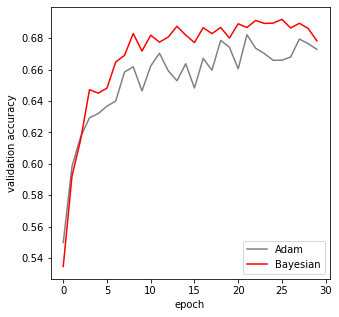

In [326]:
plt.figure(figsize=(5,5))
#plt.plot(ls,ls,color='black')
plt.plot(acc_ls,color='gray',label='Adam')
plt.plot(acc_ls_bay,color='red',label='Bayesian')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.show()

In [239]:
def prob_extraction(optimizer):
    '''
    Extract prob/acc from log file
    '''
    if optimizer == 'Adam':
        filepath = './result_adam_Apr19/log'
    else:
        filepath = './result_bayes_Apr18/log'
    
    return prob_collection

In [240]:
prob_adam = prob_extraction(optimizer='Adam',dataset='DATASET_CIFAR10',data_augmentation = False,download = True)

Files already downloaded and verified
Data Loading Done
Model Loading Done
checkpoint path: ./result_adam_Apr19/ckpts/epoch20_ckp.ckpt
Successfully Extract Predictive Entropy !


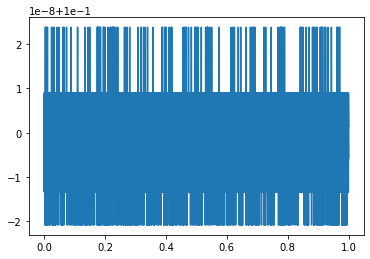

Following code is for testing:

In [ ]:
if optimizer == 'Bayessian':
    configpath = 'configs/cifar10/lenet_vogn_feature.json'
    ckptpath = './result/ckpts/epoch30_ckp.ckpt'
elif optimizer == 'Adam':
    configpath = 'configs/cifar10/lenet_adam_feature.json'
    ckptpath = './result_adam/ckpts/epoch30_ckp.ckpt'
else:
    print('Not Available Optimizer')   



## load config file    
with open(configpath) as f:
    config = json.load(f)

## set up
device = ("cuda" if torch.cuda.is_available() else "cpu")
batchsize = config['batch_size']

## load data pre-processing
data_transforms = []
if data_augmentation == True:
    ## random crop
    data_transforms.append(transforms.RandomCrop(32, padding=4))
    ## random horizontal flip
    data_transforms.append(transforms.RandomHorizontalFlip())
    ## style augmentation
    ## 接口 @Max
if dataset == 'DATASET_MNIST':
    colorized = transforms.Grayscale(num_out_channels = 3)
    data_transforms.append(colorized)
data_transforms.append(transforms.ToTensor())  
if config['normalizing_data'] == True: 
    normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    data_transforms.append(normalize)     
transform = transforms.Compose(data_transforms)  

## load data
if dataset == 'DATASET_CIFAR10':
    # CIFAR-10
    num_classes = 10
    dataset_class = datasets.CIFAR10
elif dataset == 'DATASET_SVHN':
    ## SVHN
    num_classes = 10
    dataset_class = datasets.SVHN
elif dataset == 'DATASET_MNIST':
    ## MNIST
    num_classes = 10
    dataset_class = datasets.MNIST
elif dataset == 'DATASET_Texture':
    ## Texture
    num_classes = 47
    dataset_class = datasets.DTD
elif dataset == 'DATASET_Places365':
    ## Places365
    num_classes = 434
    dataset_class = datasets.Places365
else:
    print('Unknown Dataset')
    #return
    
dataset = dataset_class(root='./data', train=False, download=download, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True, num_workers=0)    

## load model  
_, ext = os.path.splitext(config['arch_file'])
dirname = os.path.dirname(config['arch_file'])
module_path = '.'.join(os.path.split(config['arch_file'])).replace(ext, '')
module = import_module(module_path)
arch_class = getattr(module, config['arch_name'])
num_classes = 10
arch_kwargs = config['arch_args']
arch_kwargs['num_classes'] = num_classes
model = arch_class(**arch_kwargs)
setattr(model, 'num_classes', num_classes)
model.to(device)

## load checkpoint and update model
checkpoint = torch.load(ckptpath)
model.load_state_dict(checkpoint['model'])

## extract features
model.eval()
  
feature1_ls = []                                                     
feature2_ls = []
feature3_ls = []                                                     
with torch.no_grad():
    for data, target in data_loader:
        
        data, target = data.to(device), target.to(device)  
        output,feature1,feature2,feature3 = model(data)
            
        feature1_ls.append(feature1.detach().cpu().numpy().reshape(-1,1))
        feature2_ls.append(feature2.detach().cpu().numpy().reshape(-1,1))
        feature3_ls.append(feature3.detach().cpu().numpy().reshape(-1,1))

features = {'feature1':feature1_ls,'feature2':feature2_ls,'feature3':feature3_ls}        
        
#return feature

Unknown Dataset
Files already downloaded and verified


In [ ]:
train_transforms, val_transforms = [], []
train_transforms.append(transforms.ToTensor())
val_transforms.append(transforms.ToTensor())
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_transforms.append(normalize)
val_transforms.append(normalize)
train_transform = transforms.Compose(train_transforms)
val_transform = transforms.Compose(val_transforms) 

In [ ]:
dataset_class = datasets.CIFAR10
ood2_dataset = datasets.DTD


#train_dataset = dataset_class(root='./data', train=True, download=False, transform=train_transform)
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)

#val_dataset = dataset_class(root='./data', train=False, download=False, transform=val_transform)
#val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)

ood2_dataset = ood2_dataset(root='./data', download = True,transform=val_transform)
ood2_loader = torch.utils.data.DataLoader(ood2_dataset, batch_size=128, shuffle=False,num_workers=0)

In [ ]:
model.eval()
loss = 0
correct = 0
    
feature1_ls = []                                                     
feature2_ls = []
feature3_ls = []                                                     
with torch.no_grad():
    for data, target in ood2_loader:

        data, target = data.to(device), target.to(device)

        #if isinstance(optimizer, VIOptimizer):
            #output = optimizer.prediction(data)
        #else:
        #    output,_,_,_ = model(data)
            
        output,feature1,feature2,feature3 = model(data)
            
        feature1_ls.append(feature1.detach().cpu().numpy().reshape(-1,1))
        feature2_ls.append(feature2.detach().cpu().numpy().reshape(-1,1))
        feature3_ls.append(feature3.detach().cpu().numpy().reshape(-1,1))
                                
        val_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

val_loss /= len(ood2_loader.dataset)
val_accuracy = 100. * correct / len(ood2_loader.dataset)

print('\nEval: Average loss: {:.4f}, Accuracy: {:.0f}/{} ({:.2f}%)\n'.format(val_loss, correct, len(ood2_loader.dataset), val_accuracy))

RuntimeError: output with shape [1, 28, 28] doesn't match the broadcast shape [3, 28, 28]